<a href="https://colab.research.google.com/github/worldwidekatie/Build_Week_2/blob/master/Build_Week_Two_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build Week Two Notebook
## Can we predict the retweet status of Russian troll tweets?

I am using a dataset of over 3 million Russian troll tweets from fivethirtyeight.

Dataset: [Three Million Troll Tweets](https://www.kaggle.com/fivethirtyeight/russian-troll-tweets/version/1)


Header | Definition
---|---------
`external_author_id` | An author account ID from Twitter 
`author` | The handle sending the tweet
`content` | The text of the tweet
`region` | A region classification, as [determined by Social Studio](https://help.salesforce.com/articleView?   id=000199367&type=1)
`language` | The language of the tweet
`publish_date` | The date and time the tweet was sent
`harvested_date` | The date and time the tweet was collected by Social Studio
`following` | The number of accounts the handle was following at the time of the tweet
`followers` | The number of followers the handle had at the time of the tweet
`updates` | The number of “update actions” on the account that authored the tweet, including tweets, retweets and likes
`post_type` | Indicates if the tweet was a retweet or a quote-tweet
`account_type` | Specific account theme, as coded by Linvill and Warren
`retweet` | A binary indicator of whether or not the tweet is a retweet
`account_category` | General account theme, as coded by Linvill and Warren
`new_june_2018` | A binary indicator of whether the handle was newly listed in June 2018

I started by subsetting the sample. The code for that can be found on [GitHub](https://github.com/worldwidekatie/Build_Week_2/blob/master/Data_Frame_Creation.ipynb). 

The original dataframe was split up between 9 CSVs. I first filtered each CSV to include only English-language tweets then took a random sample from each containing ```frac=0.005``` and concatonated those to create a dataframe of 10,646 English-Language IRA tweets.

The following analysis is how I fit first a logistic regression model and then a random forest classification model to answer the question, can we predict whether or not an IRA tweet is a re-tweet or not?




In [10]:
import sklearn as sk
!pip install category_encoders
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [47]:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from scipy import stats
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance

     |████████████████████████████████| 112kB 2.8MB/s 
     |████████████████████████████████| 245kB 2.9MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 1.5MB 8.8MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 614kB 19.2MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 8.7MB 23.0MB/s 
     |████████████████████████████████| 296kB 29.3MB/s 
  Created wheel for tangled-up-in-unicode: filename=tangled_up_in_unicode-0.0.4-cp36-none-any.whl size=1545723 sha256=2c1b26b529a702e409124392d84510db5fc4a4ec5dff05cb34835c5b597eaf97
  Stored in directory: /root/.cache/pip/wheels/f9/f1/84/923abc0c2a75358b0bc28f87de02c7aa328c731ce68317d97d
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=4dfb91e8b7613fb9db166f31586f0243589f1ae38435da2b2041c4d75332d820
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9

     |████████████████████████████████| 57.7MB 68kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=79874e2557c08b0f4d70a15945aa27d776d7daeaff6713cb0ae53fac623a26f9
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox
     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394123 sha256=d10c85adc4aab6434e86eacfb0362473e6f544bc3e1fc69cfdb9ff86028541f0
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [0]:
df_orig = pd.read_csv('https://raw.githubusercontent.com/worldwidekatie/Build_Week_2/master/Final_IRA.csv')

In [3]:
df = df_orig[['content',	'region',	'language',	'publish_date',	'harvested_date',	
             'following',	'followers',	'updates',	'post_type',	'account_type',	
             'new_june_2018',	'retweet',	'account_category']]
df.head()

,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,#adee RT davis1988will: Congratulations for Ma...,United States,English,7/30/2017 21:18,7/30/2017 21:18,995,313,332,QUOTE_TWEET,Right,0,1,RightTroll
1,RT SSOL getting attention. It's penny play day...,United States,English,6/27/2015 21:47,6/27/2015 21:48,7,35,2213,NaN,Commercial,1,0,Commercial
2,#laup SHOCK VIDEO : Antifa Thugs Break a Latin...,Unknown,English,8/17/2017 2:20,8/17/2017 2:21,36,6,793,NaN,Right,0,0,RightTroll
3,PROOF Melania Has Done FAR MORE for Disaster R...,Unknown,English,9/2/2017 3:09,9/2/2017 3:09,4984,925,3411,NaN,Right,0,0,RightTroll
4,"An USC professor, Raphael Bostic, named first ...",United States,English,3/15/2017 22:00,3/15/2017 22:00,14207,17561,3852,NaN,left,0,0,LeftTroll


### The baseline for my model is 59% because 59% of the sample tweets are NOT retweets.

In [4]:
df['retweet'].value_counts(normalize=True)

0    0.592711
1    0.407289
Name: retweet, dtype: float64

###I'll begin by splitting the sample based on time because I'm interested in knowing if models trained on tweets around the time of the 2016 election can be used for tweets surrounding the 2018 election or not.

In [5]:
train = df[(df['new_june_2018'] == 0)]
test = df[(df['new_june_2018'] == 1)]
train.shape, test.shape

((9380, 13), (1266, 13))

### I used a random test/train split for training and validation data.

In [6]:
train, val = train_test_split(train, random_state=42)
train.shape, val.shape

((7035, 13), (2345, 13))

###I've decided to replace NaNs in region with "Unknown" during my data wrangling process rather than using an imputer because it is the only feature column I'm using that contains NaNs and already contains "Unknown" as a category.

###NaNs in post_type represent zero or not a re-tweet or quote-tweet. I am not using post_type because it is nearly identitical to retweet and would contribute to data leakage.

In [24]:
df.isna().sum()

content                0
region                 3
language               0
publish_date           0
harvested_date         0
following              0
followers              0
updates                0
post_type           6310
account_type           1
new_june_2018          0
retweet                0
account_category       0
dtype: int64

In [8]:
def wrangle(X):
  X=X
  X['region'] = X['region'].replace({np.NaN: 'Unknown'})

  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

target = 'retweet'
features = ['region',	'publish_date',	'harvested_date',
             'following',	'followers',	'updates', 'account_type',	
            	'account_category']

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### I'm beginning with a logistic regression model using a one hot encoder

In [11]:
pipeline = make_pipeline(
    ce.OneHotEncoder(),
    LogisticRegression()
)

pipeline.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### The accuracy for this model is higher than the accuracy for my baseline by 30 points.

In [12]:
print("Train Accuracy:", pipeline.score(X_train, y_train))
print("Validation Accuracy:", pipeline.score(X_val, y_val))

Train Accuracy: 0.8605543710021322
Validation Accuracy: 0.864818763326226


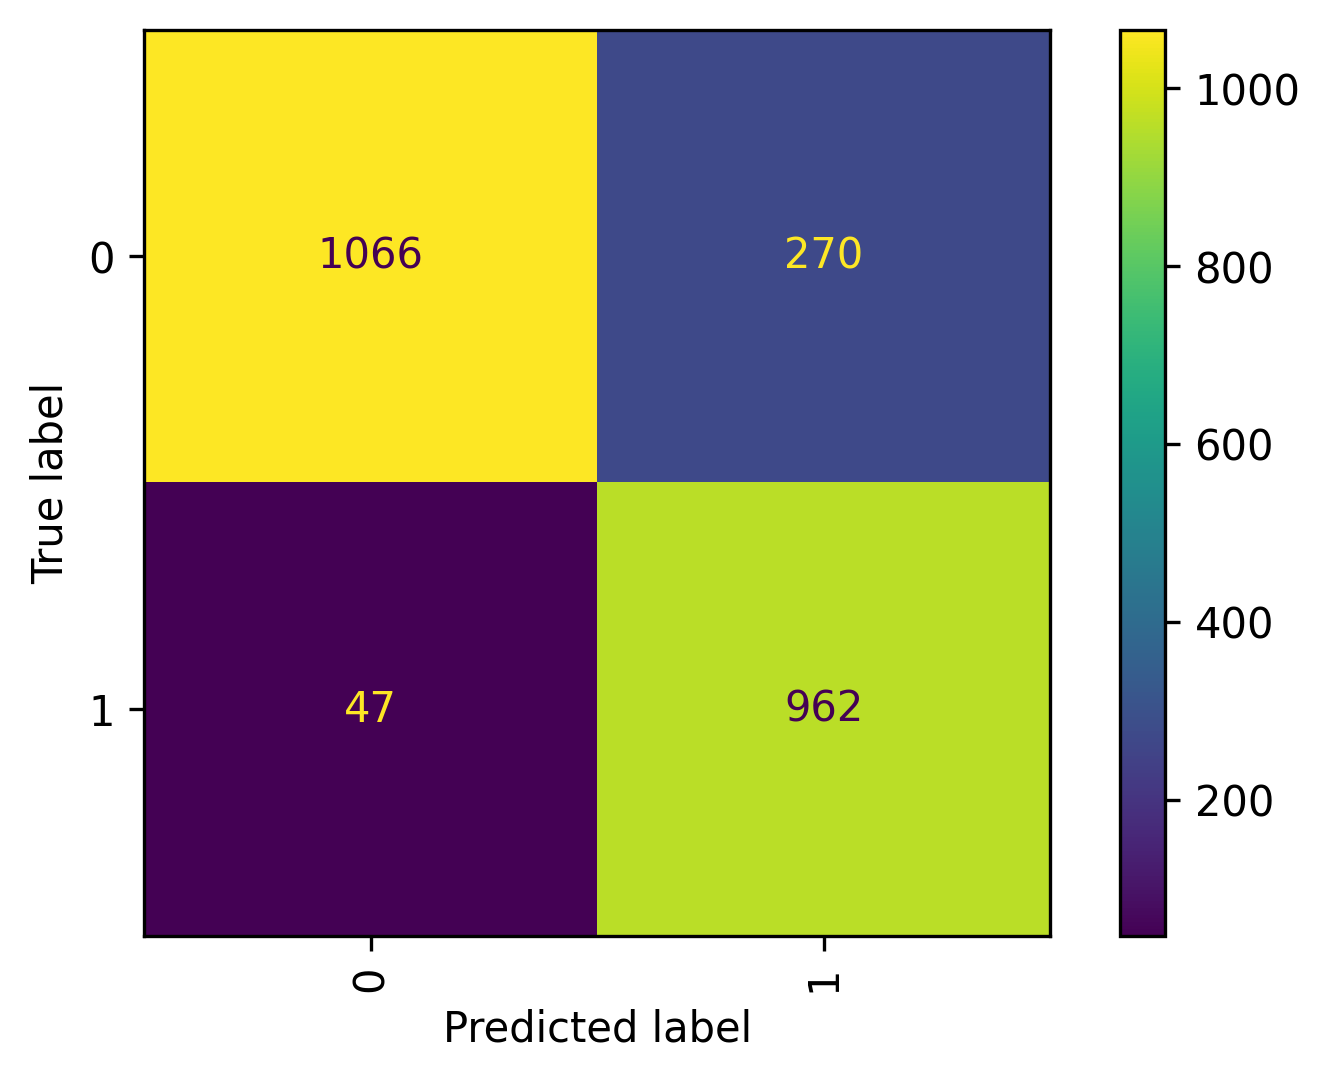

In [15]:
plt.rcParams['figure.dpi'] = 300

plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

In [19]:
y_pred = pipeline.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87      1336
           1       0.78      0.95      0.86      1009

    accuracy                           0.86      2345
   macro avg       0.87      0.88      0.86      2345
weighted avg       0.88      0.86      0.87      2345



### Next I'll make a random forest classifier using ordinal encoding.

In [20]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)
param_distributions = { 
    'randomforestclassifier__max_depth': [20,21,22,23,24,25,26,27,28,29,30], 
    'randomforestclassifier__min_samples_leaf': [10,11,12,13,14,15,16,17,18,19,20]
}


search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='accuracy', 
    verbose=1, 
    return_train_score=True
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   12.6s finished


### It did beat my linear regression model by 7 points on training data and 5 points on validation data.

In [21]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation Accuracy', -search.best_score_)
pipeline = search.best_estimator_
print("Train Accuracy:", pipeline.score(X_train, y_train))
print("Validation Accuracy:", pipeline.score(X_val, y_val))

Best hyperparameters {'randomforestclassifier__min_samples_leaf': 13, 'randomforestclassifier__max_depth': 24}
Cross-validation Accuracy -0.9175550817341862
Train Accuracy: 0.9344705046197583
Validation Accuracy: 0.9159914712153518


In [25]:
print("Test Accuracy:", pipeline.score(X_test, y_test))

Test Accuracy: 0.5624012638230648


In [27]:
y_test.value_counts(normalize=True)

0    0.71643
1    0.28357
Name: retweet, dtype: float64

In [28]:
y_val.value_counts(normalize=True)

0    0.569723
1    0.430277
Name: retweet, dtype: float64

In [29]:
y_train.value_counts(normalize=True)

0    0.578109
1    0.421891
Name: retweet, dtype: float64

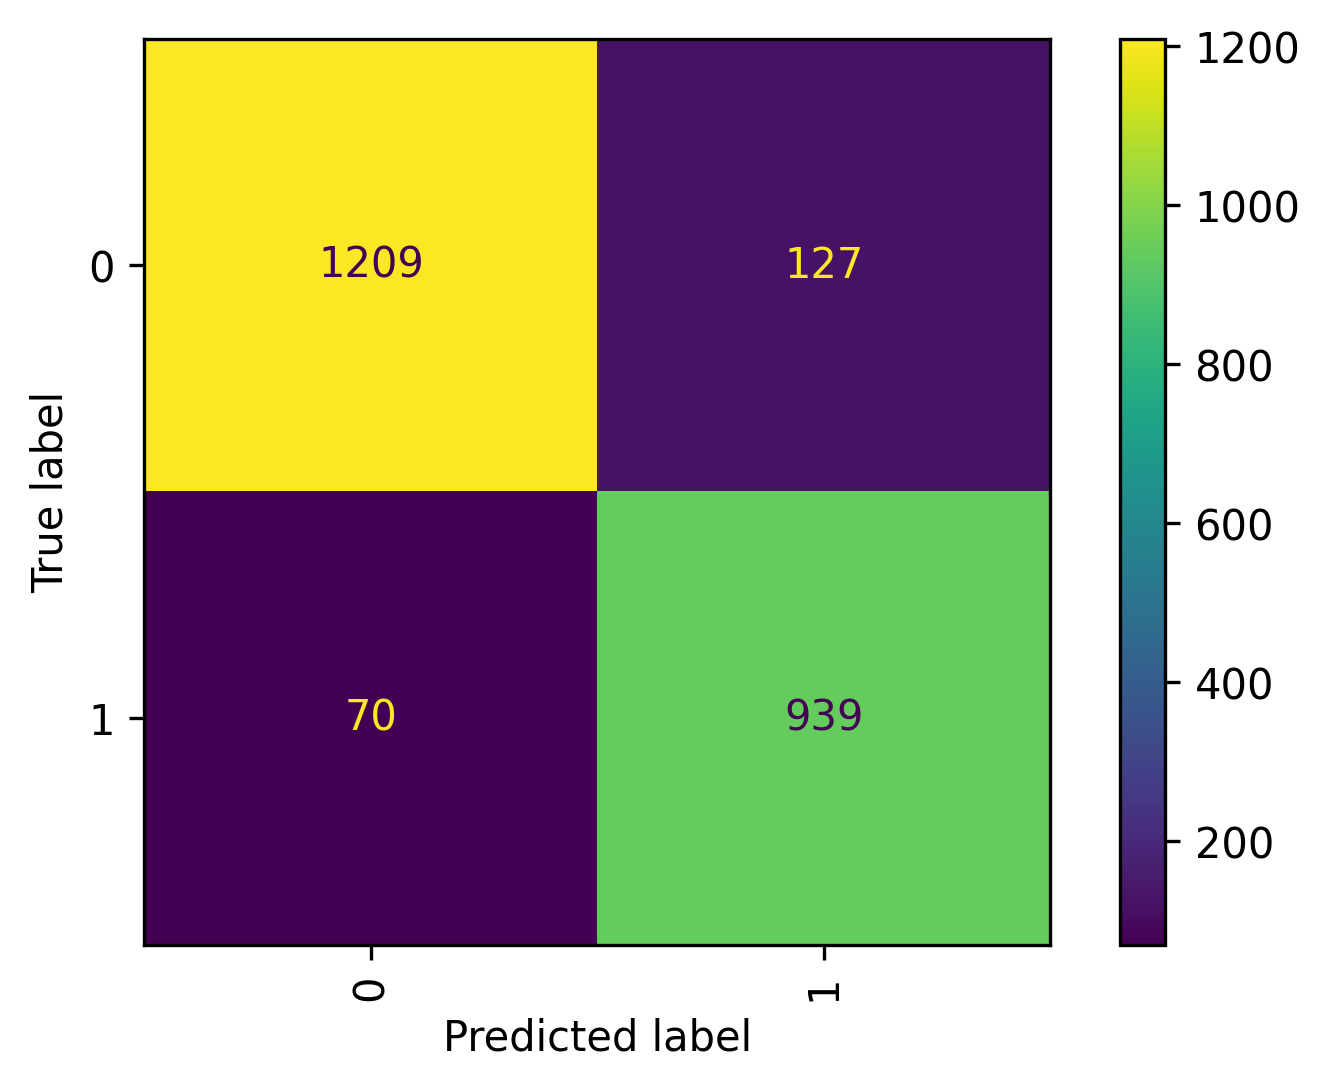

In [22]:
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

### It also beat the logistic regression model on precision and recall in every category except for retweet recall which was two points higher for logistic regression. I'm going to stick with this model due it's overall benefits.

In [23]:
y_pred = pipeline.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92      1336
           1       0.88      0.93      0.91      1009

    accuracy                           0.92      2345
   macro avg       0.91      0.92      0.91      2345
weighted avg       0.92      0.92      0.92      2345



#The model fails on test accuracy, however
### It's the exact same as our baseline and actually performs *worse* than a majority classifier would have.

In [30]:
print("Test Accuracy:", pipeline.score(X_test, y_test))

Test Accuracy: 0.5624012638230648


In [32]:
y_test.value_counts(normalize=True)

0    0.71643
1    0.28357
Name: retweet, dtype: float64

In [33]:
y_val.value_counts(normalize=True)

0    0.569723
1    0.430277
Name: retweet, dtype: float64

In [34]:
y_train.value_counts(normalize=True)

0    0.578109
1    0.421891
Name: retweet, dtype: float64

### Our testing and training data based on a time split are different at a statistically significant level and that is too much for our model to handle. This is not a good model to make predictions based on future data.

In [35]:
stats.ttest_ind(y_train, y_test, nan_policy='omit')

Ttest_indResult(statistic=9.29214135960949, pvalue=1.899740371363273e-20)

### It can, however, give us some interesting insights into data.

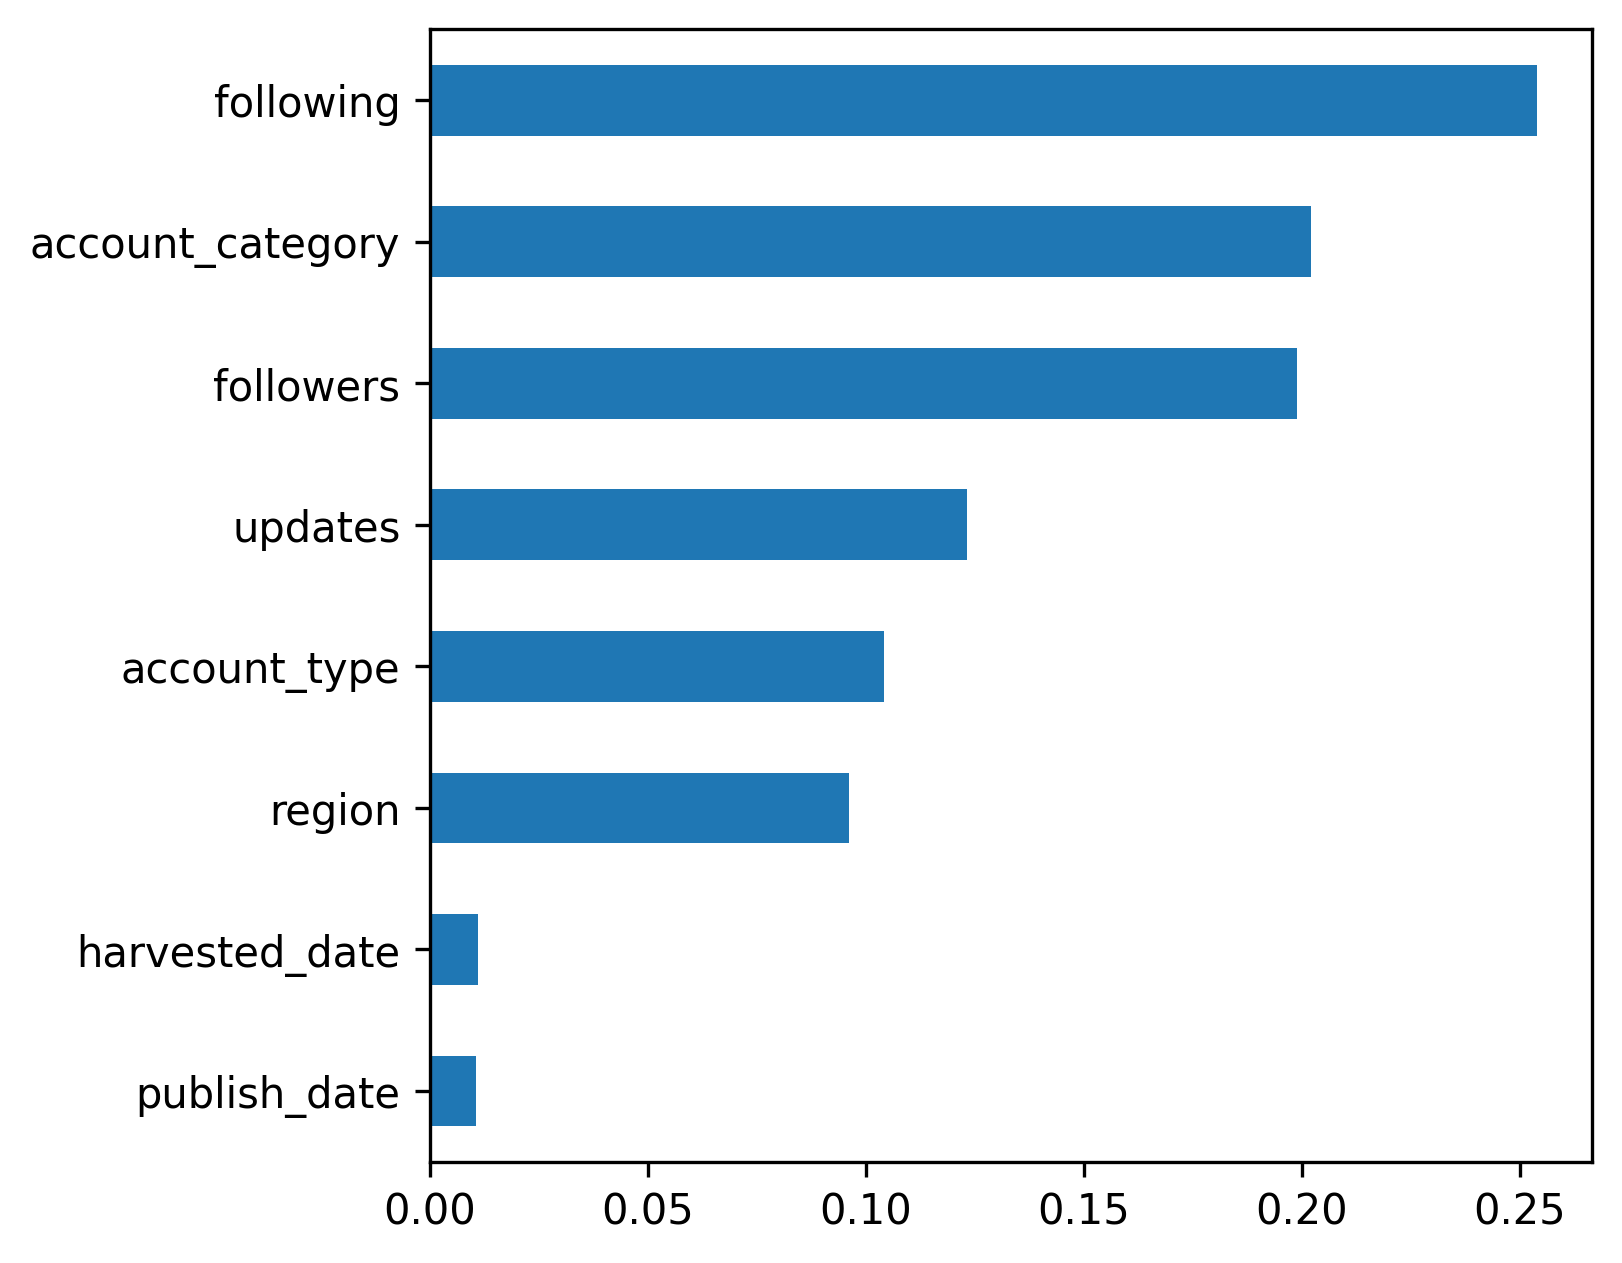

In [38]:
model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(5,5))
importances.sort_values().plot.barh();

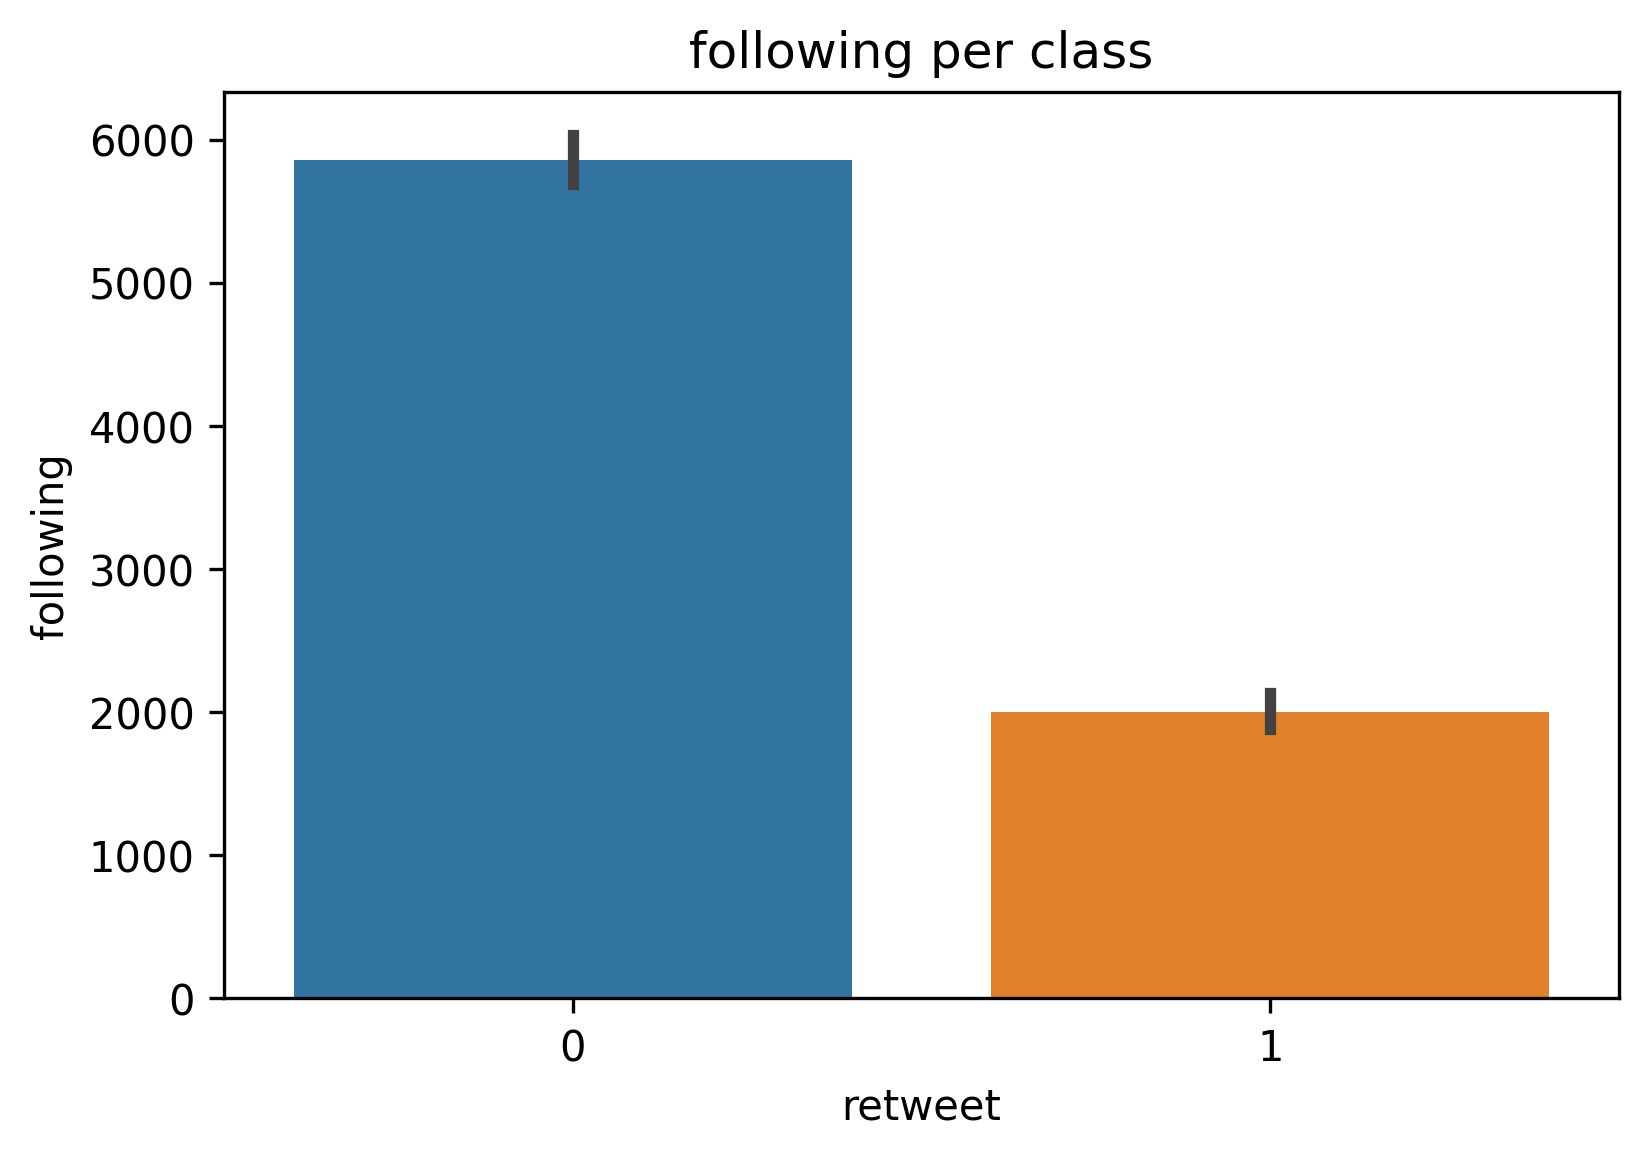

In [40]:
ax = sns.barplot(x='retweet', y="following", data=df).set_title('following per class')
plt.show();

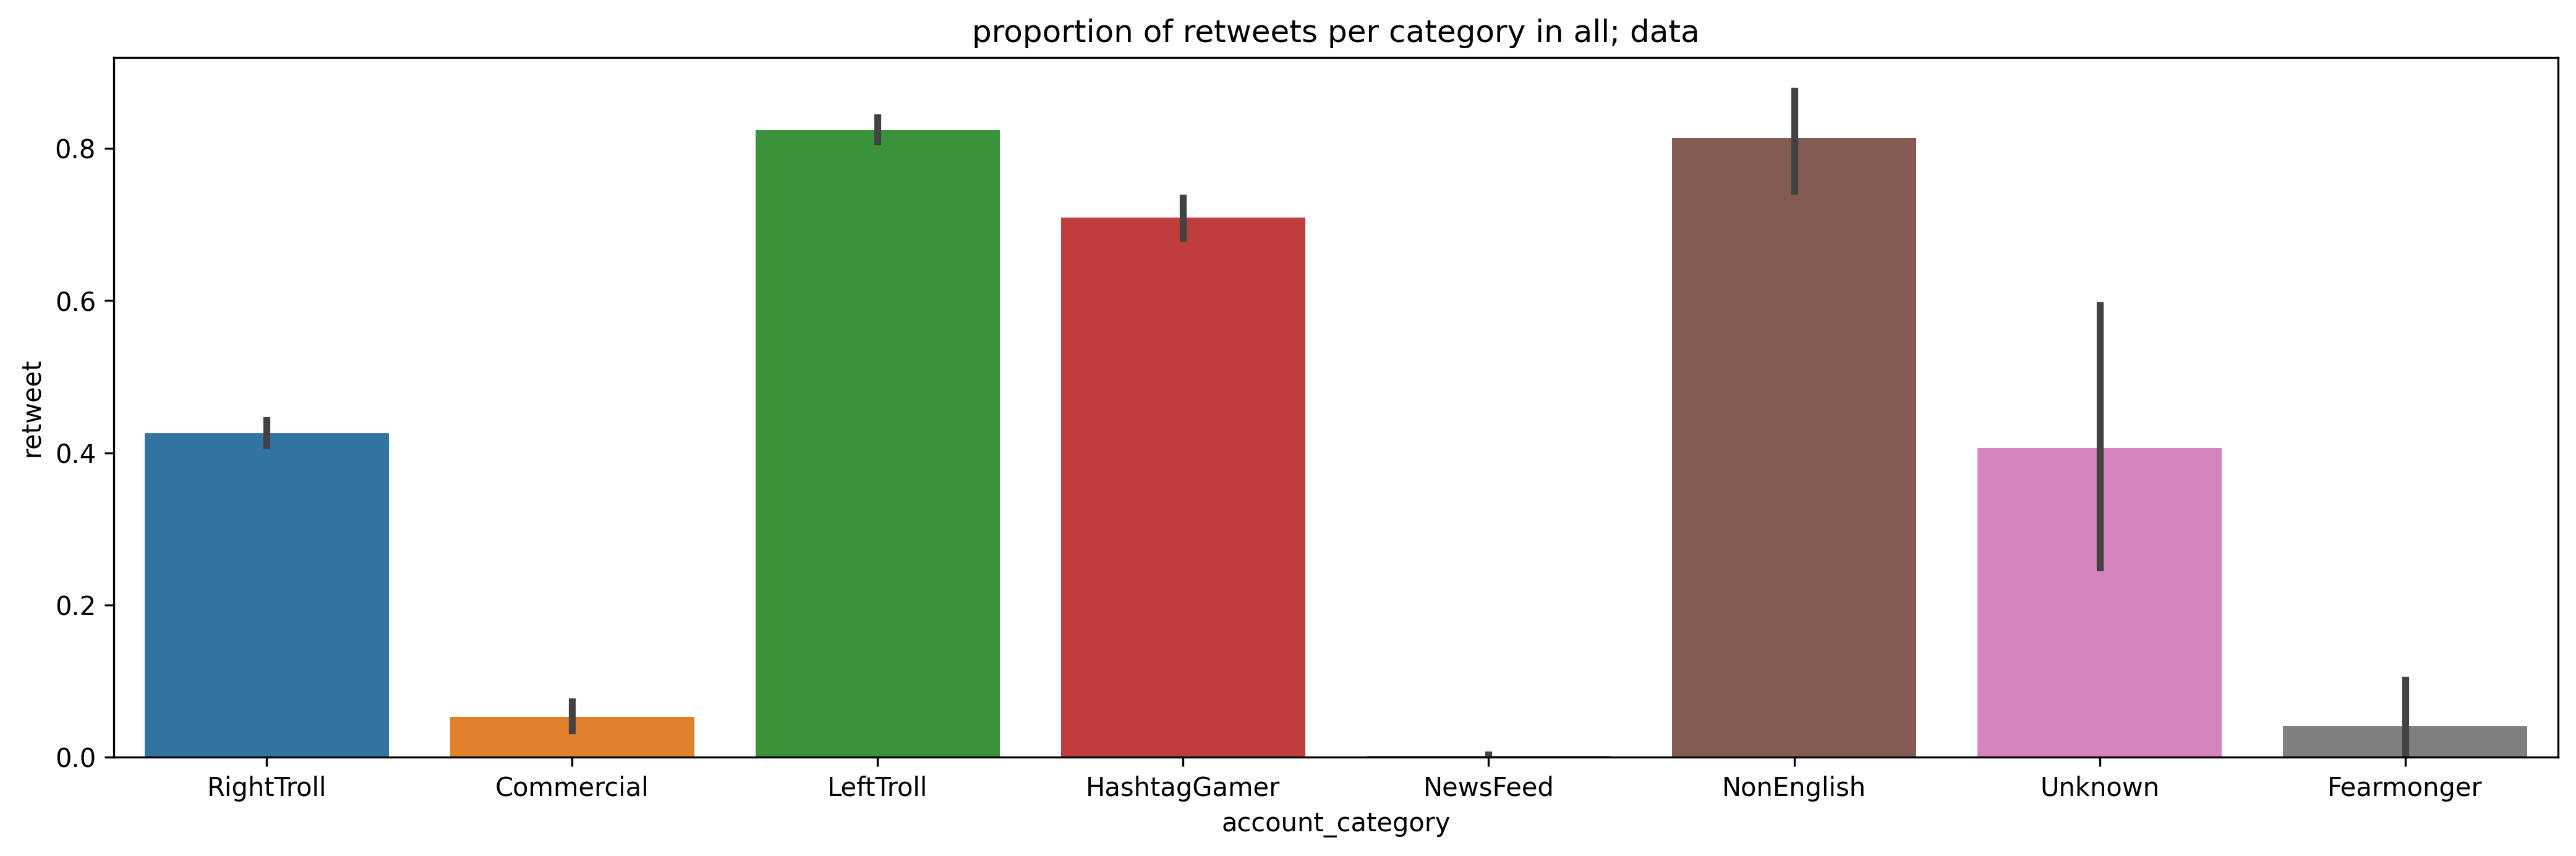

In [56]:
f, ax = plt.subplots(figsize=(17, 5))
ax = sns.barplot(x='account_category', y="retweet", data=df).set_title('proportion of retweets per category in all; data')
plt.show();

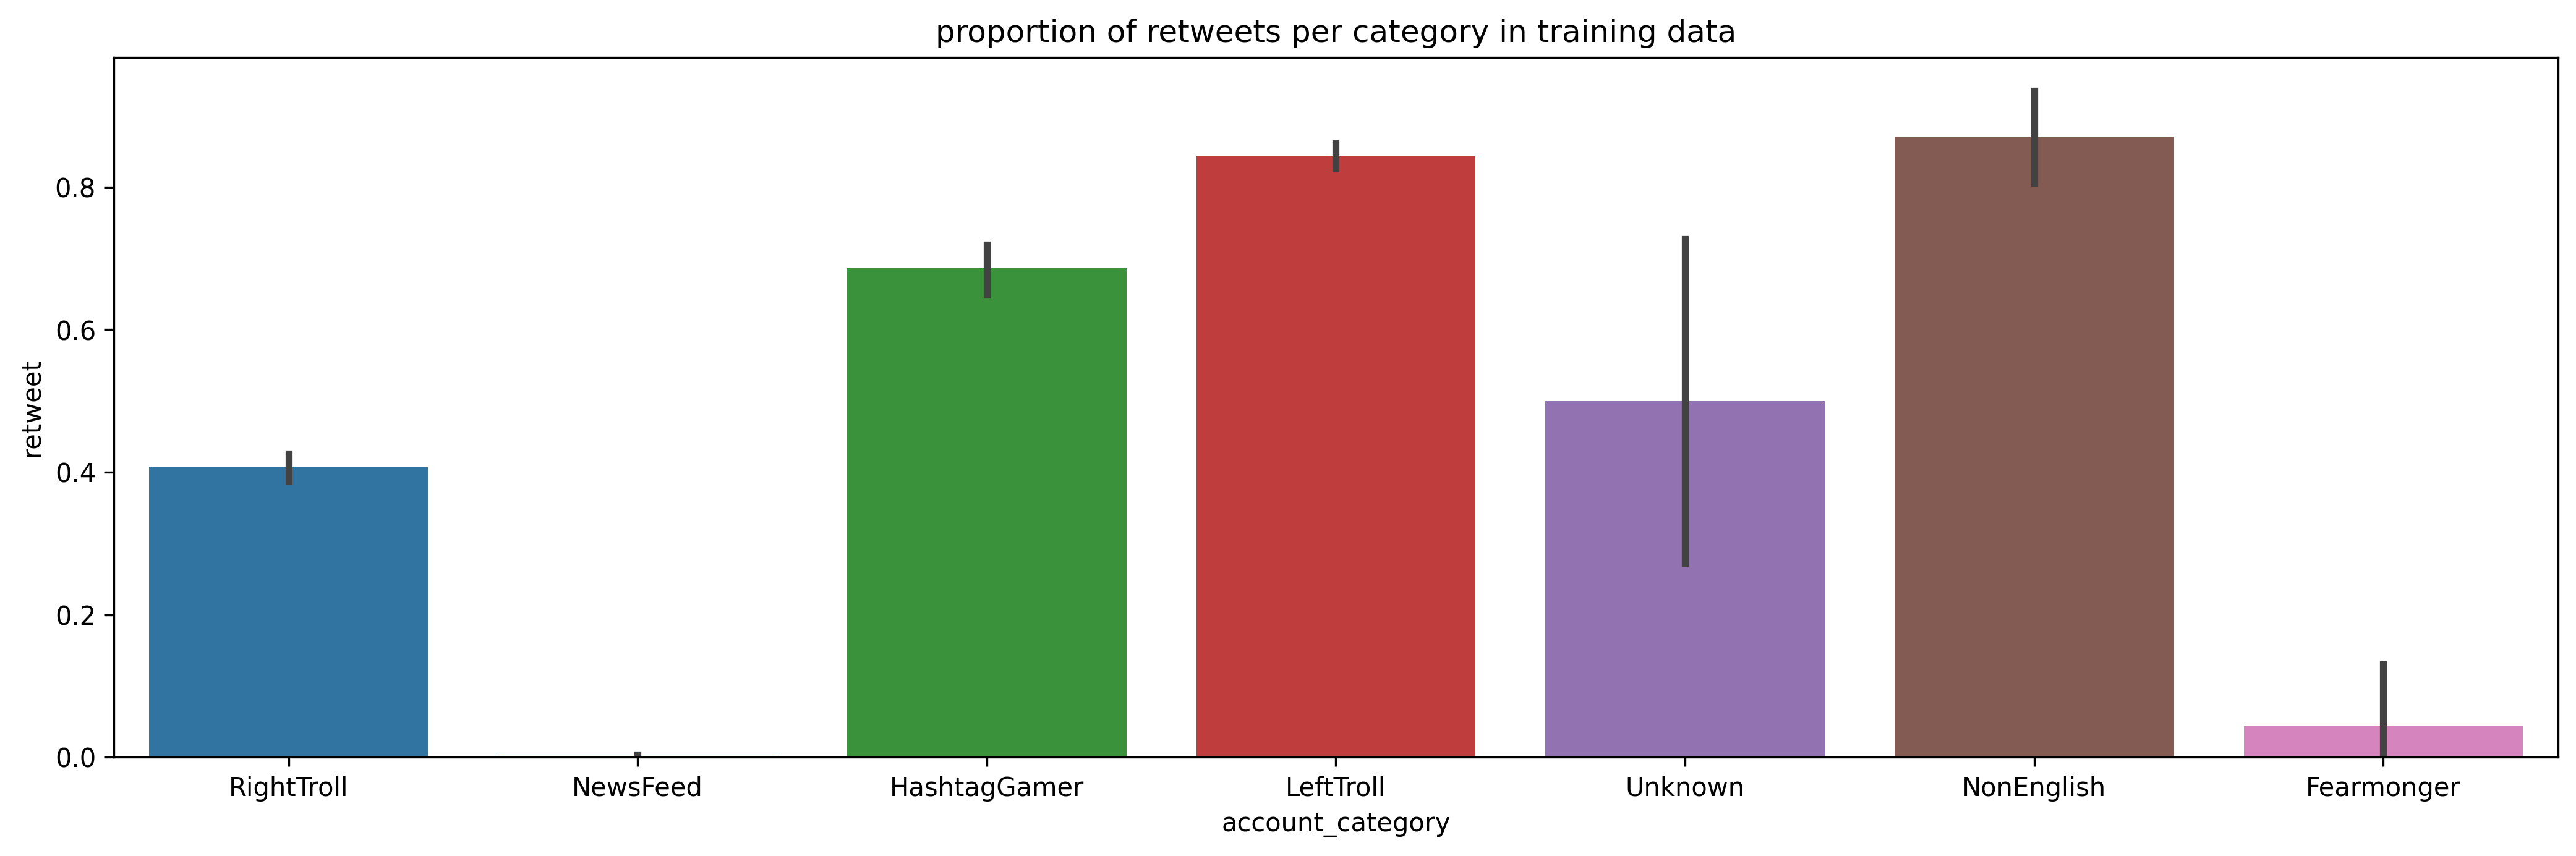

In [55]:
f, ax = plt.subplots(figsize=(17, 5))
ax = sns.barplot(x='account_category', y="retweet", data=train).set_title('proportion of retweets per category in training data')
plt.show();

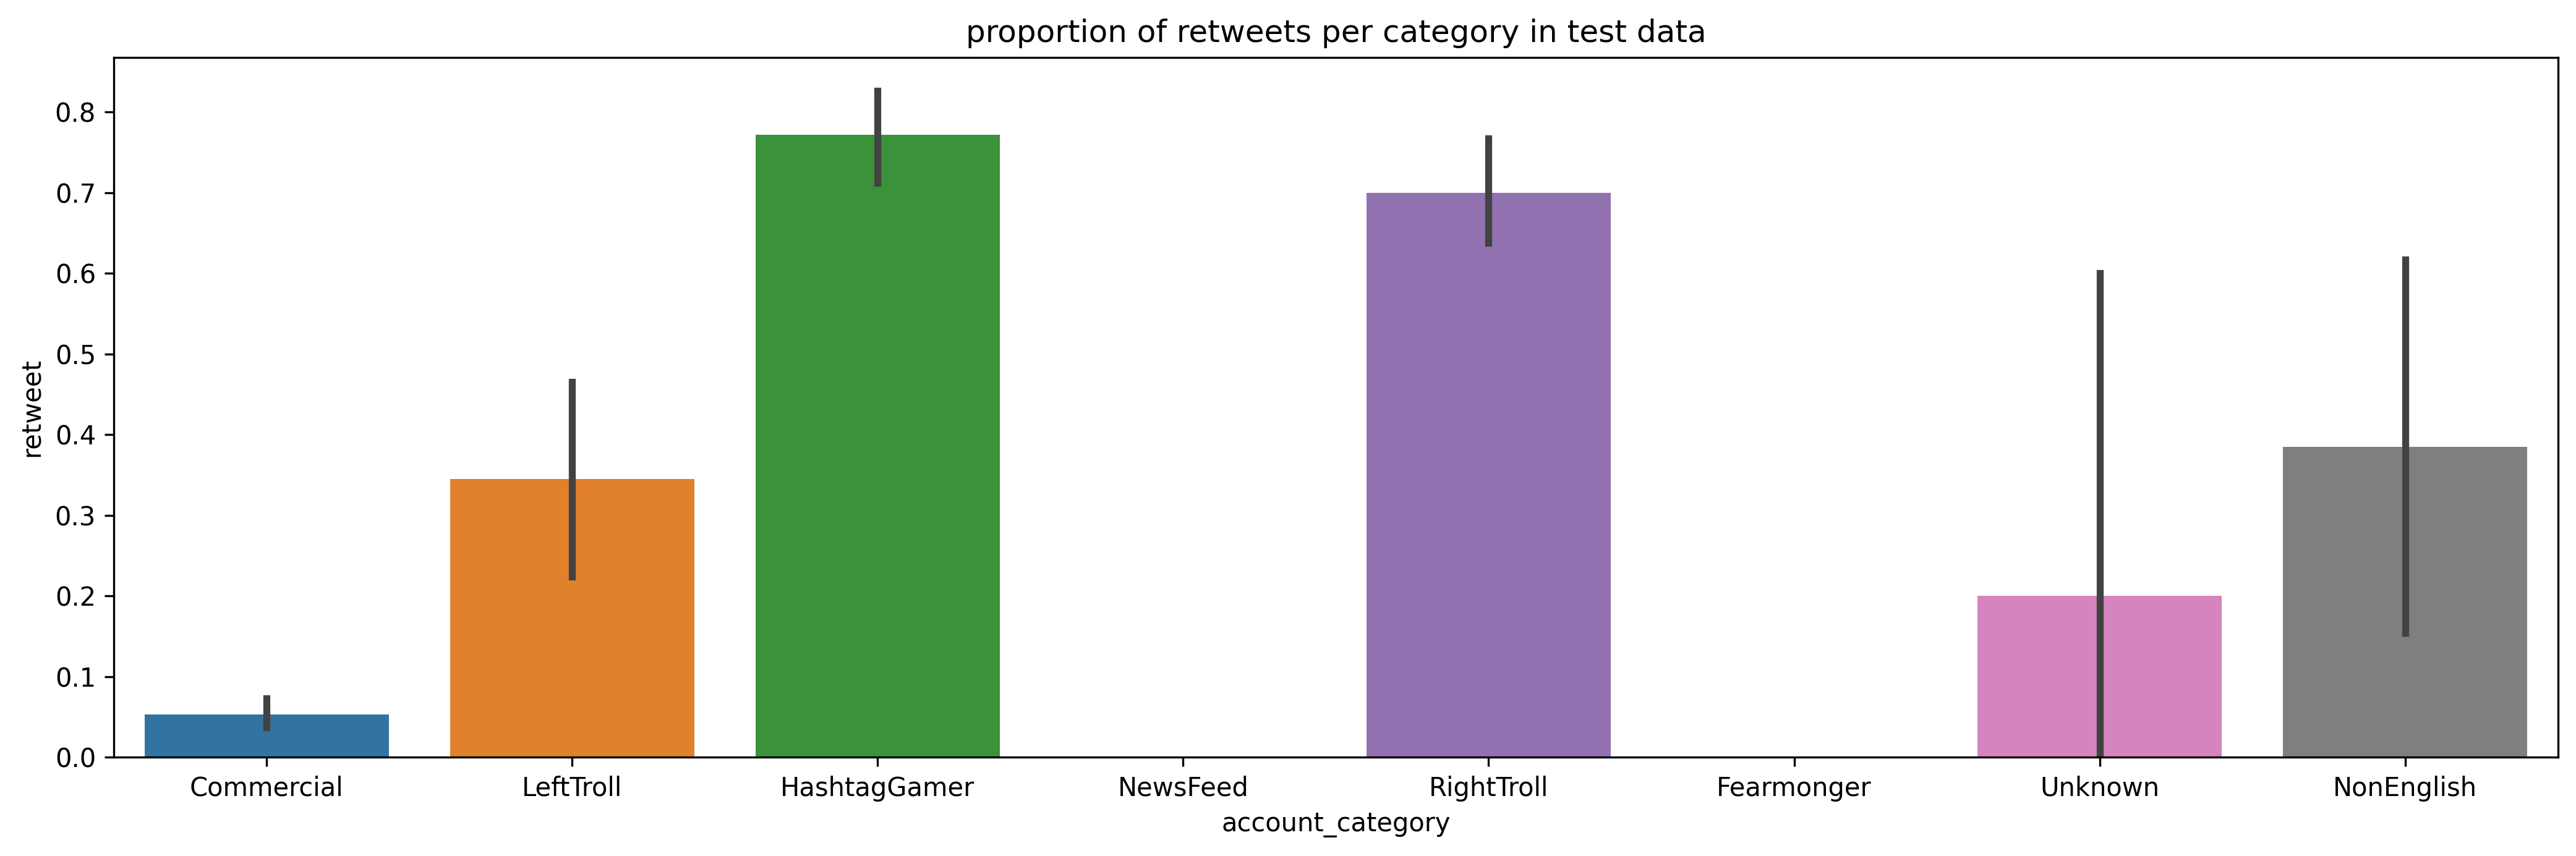

In [54]:
f, ax = plt.subplots(figsize=(17, 5))
ax = sns.barplot(x='account_category', y="retweet", data=test).set_title('proportion of retweets per category in test data')
plt.show();

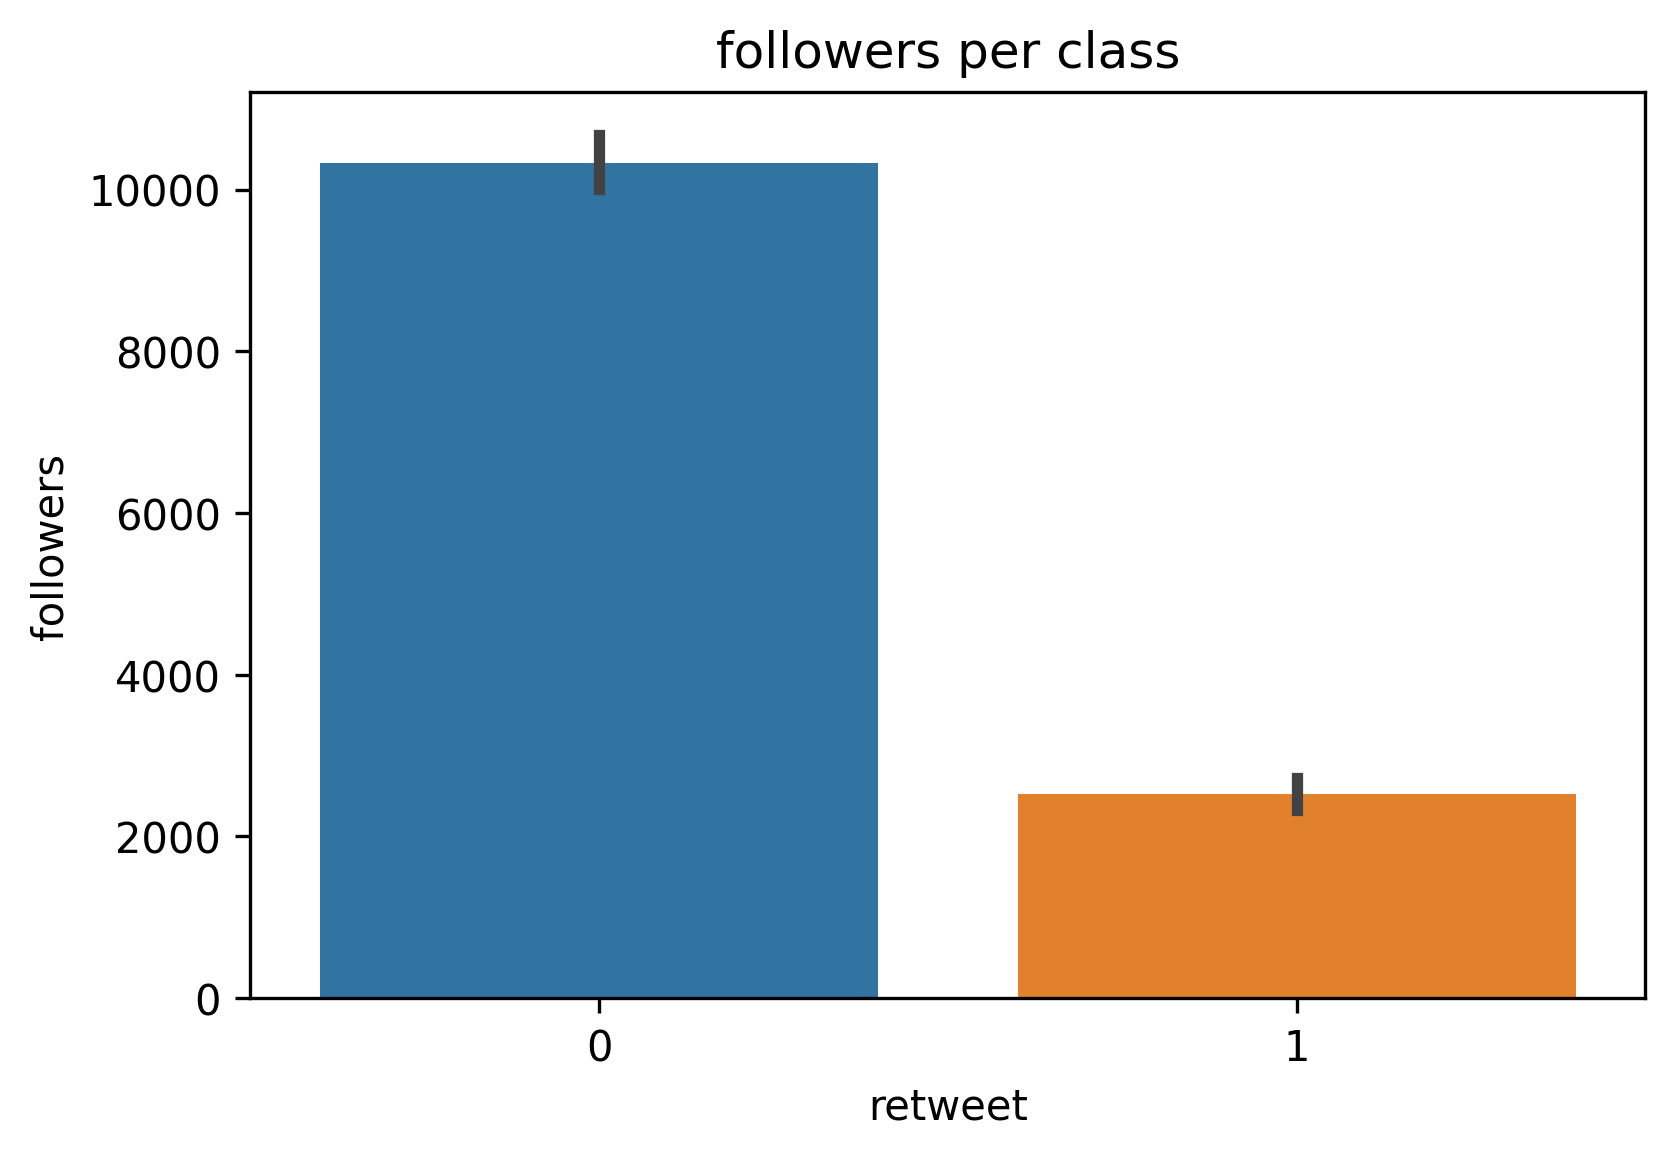

In [42]:
ax = sns.barplot(x='retweet', y="followers", data=df).set_title('followers per class')
plt.show();

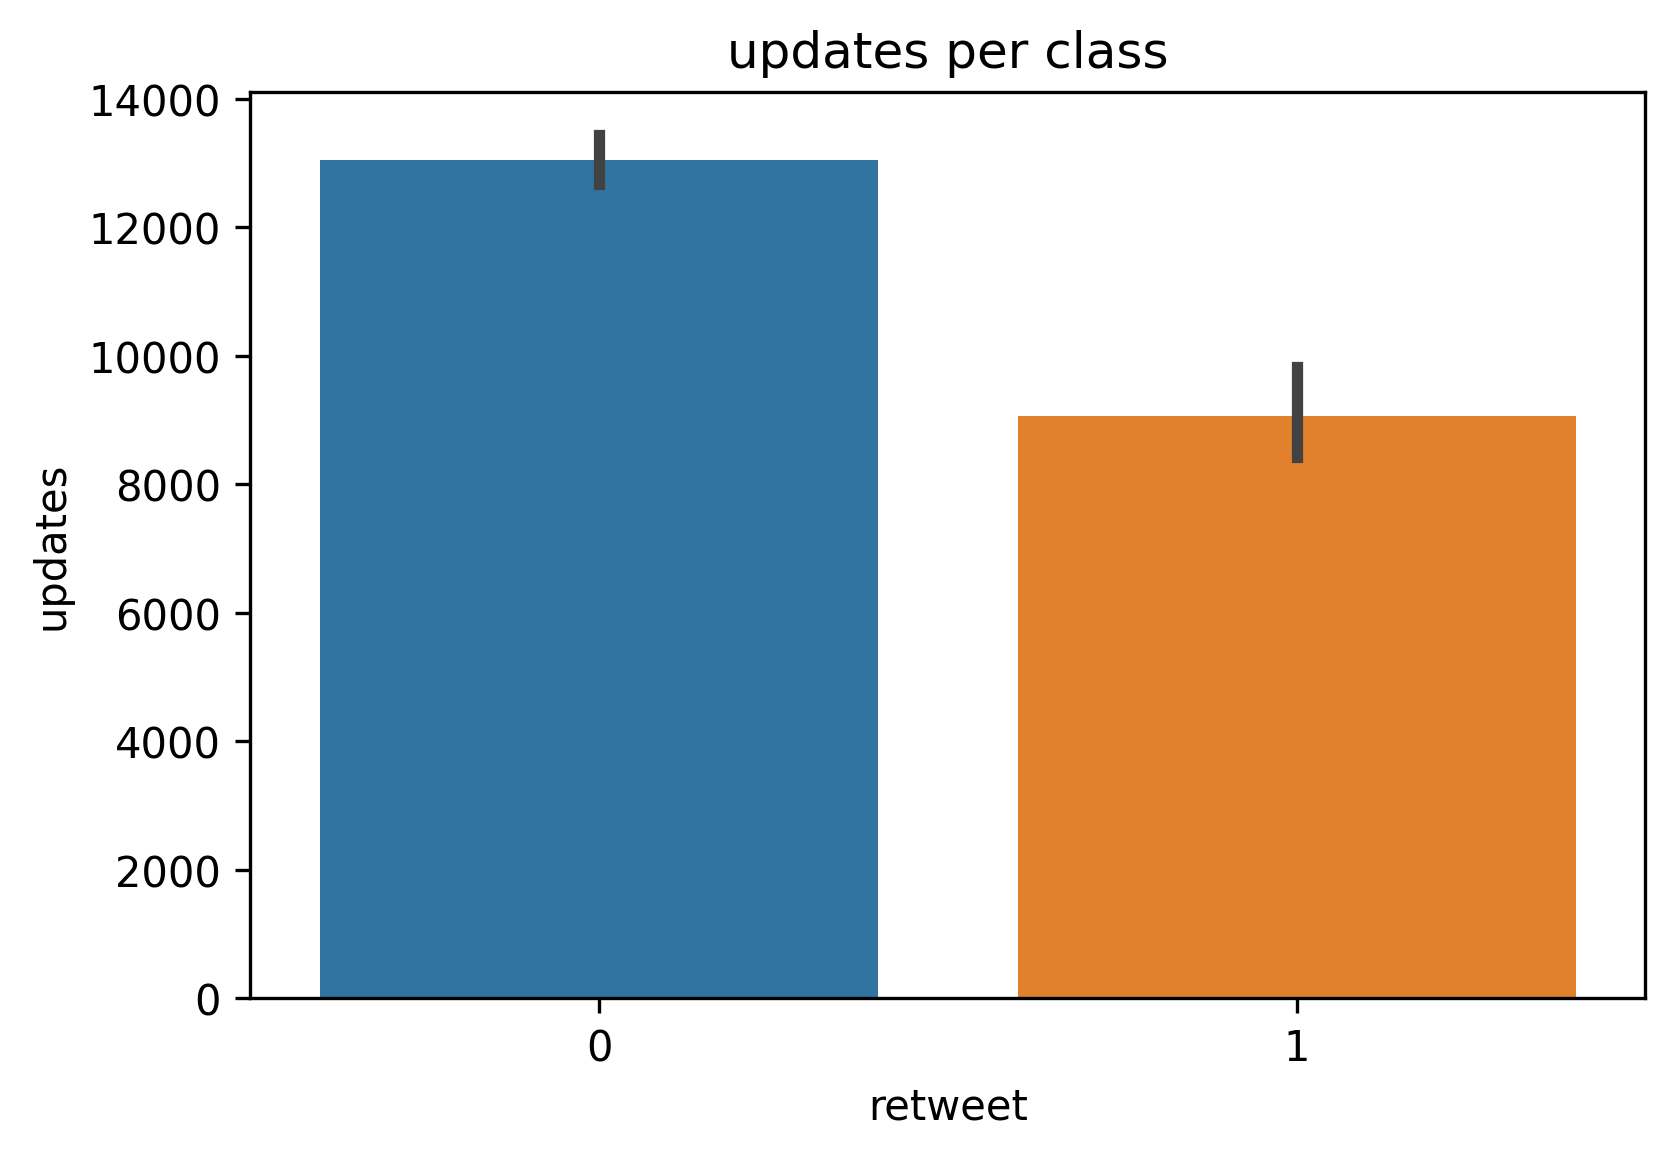

In [43]:
ax = sns.barplot(x='retweet', y="updates", data=df).set_title('updates per class')
plt.show();

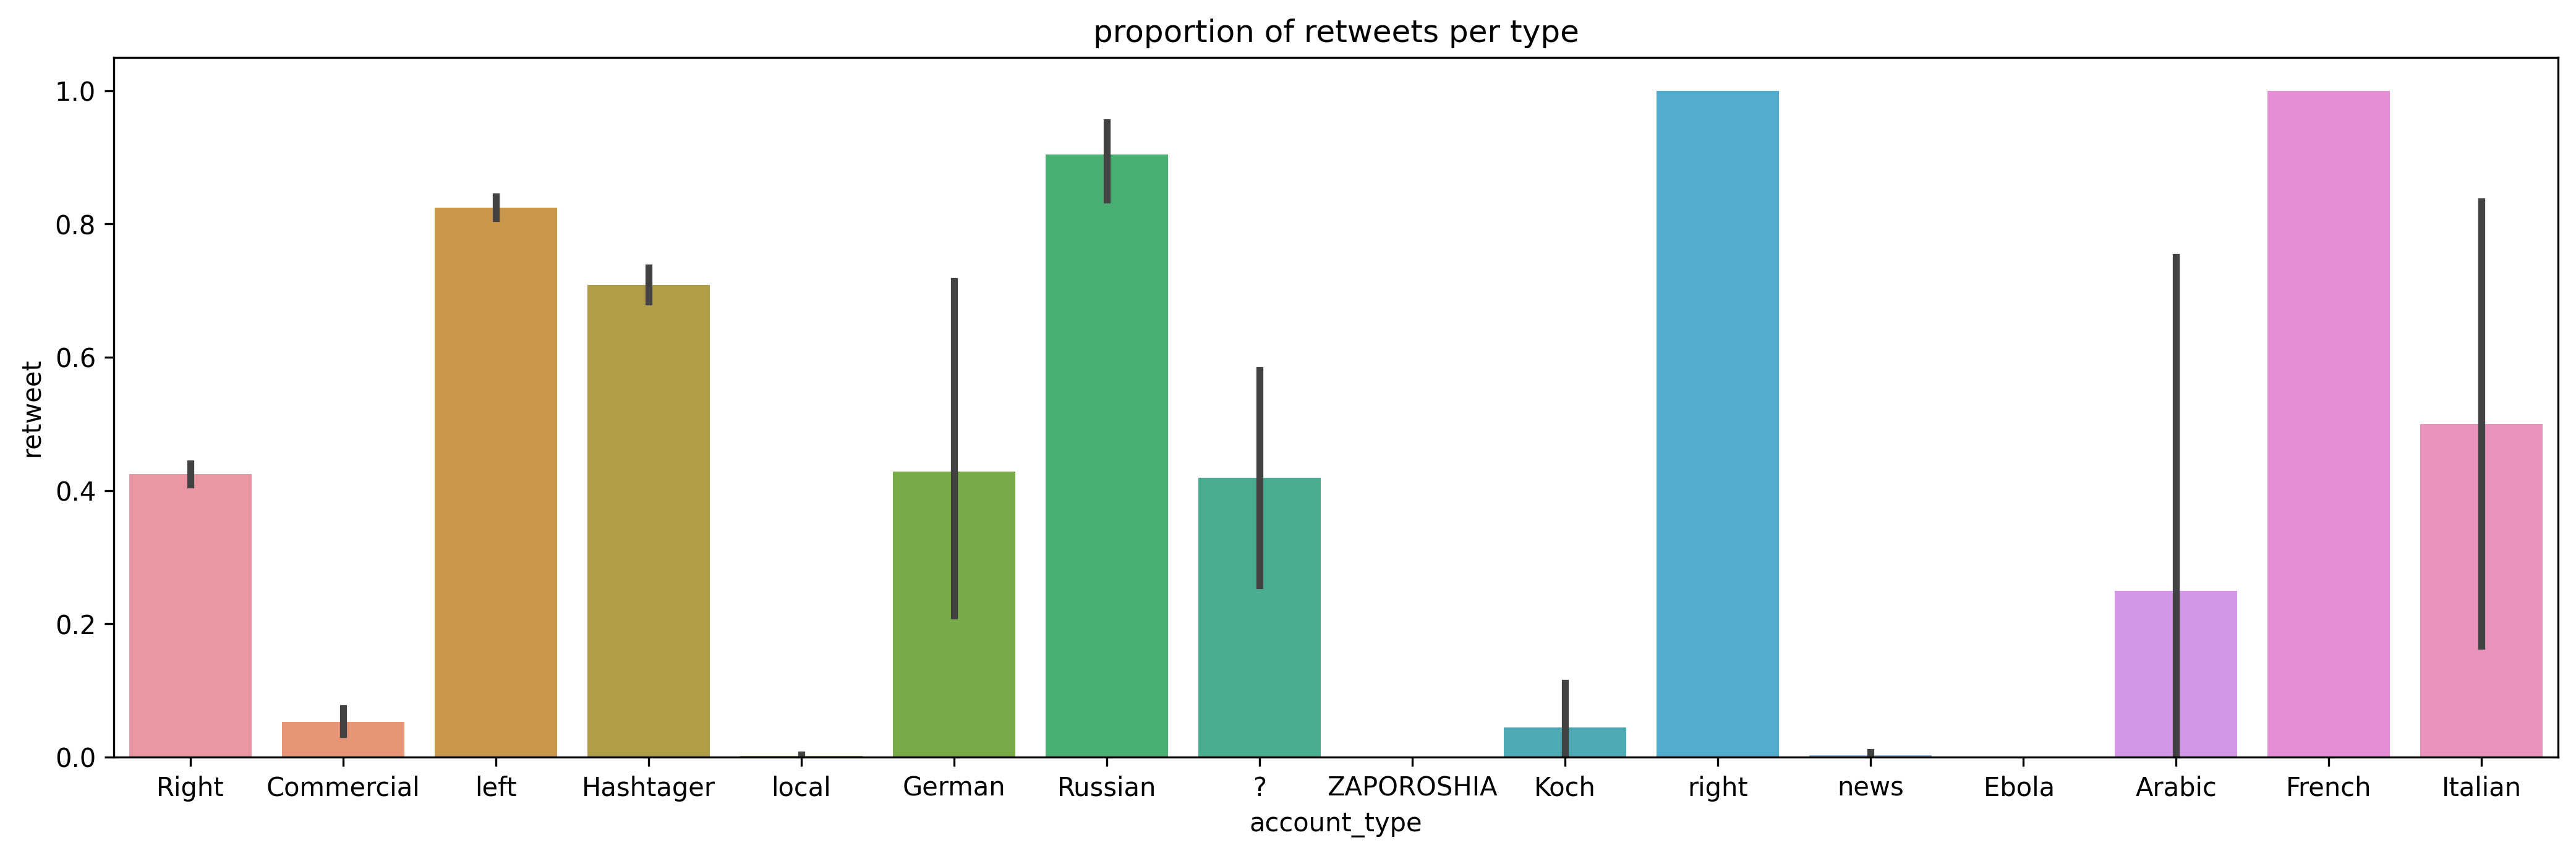

In [44]:
f, ax = plt.subplots(figsize=(17, 5))
ax = sns.barplot(x='account_type', y="retweet", data=df).set_title('proportion of retweets per type')
plt.show();

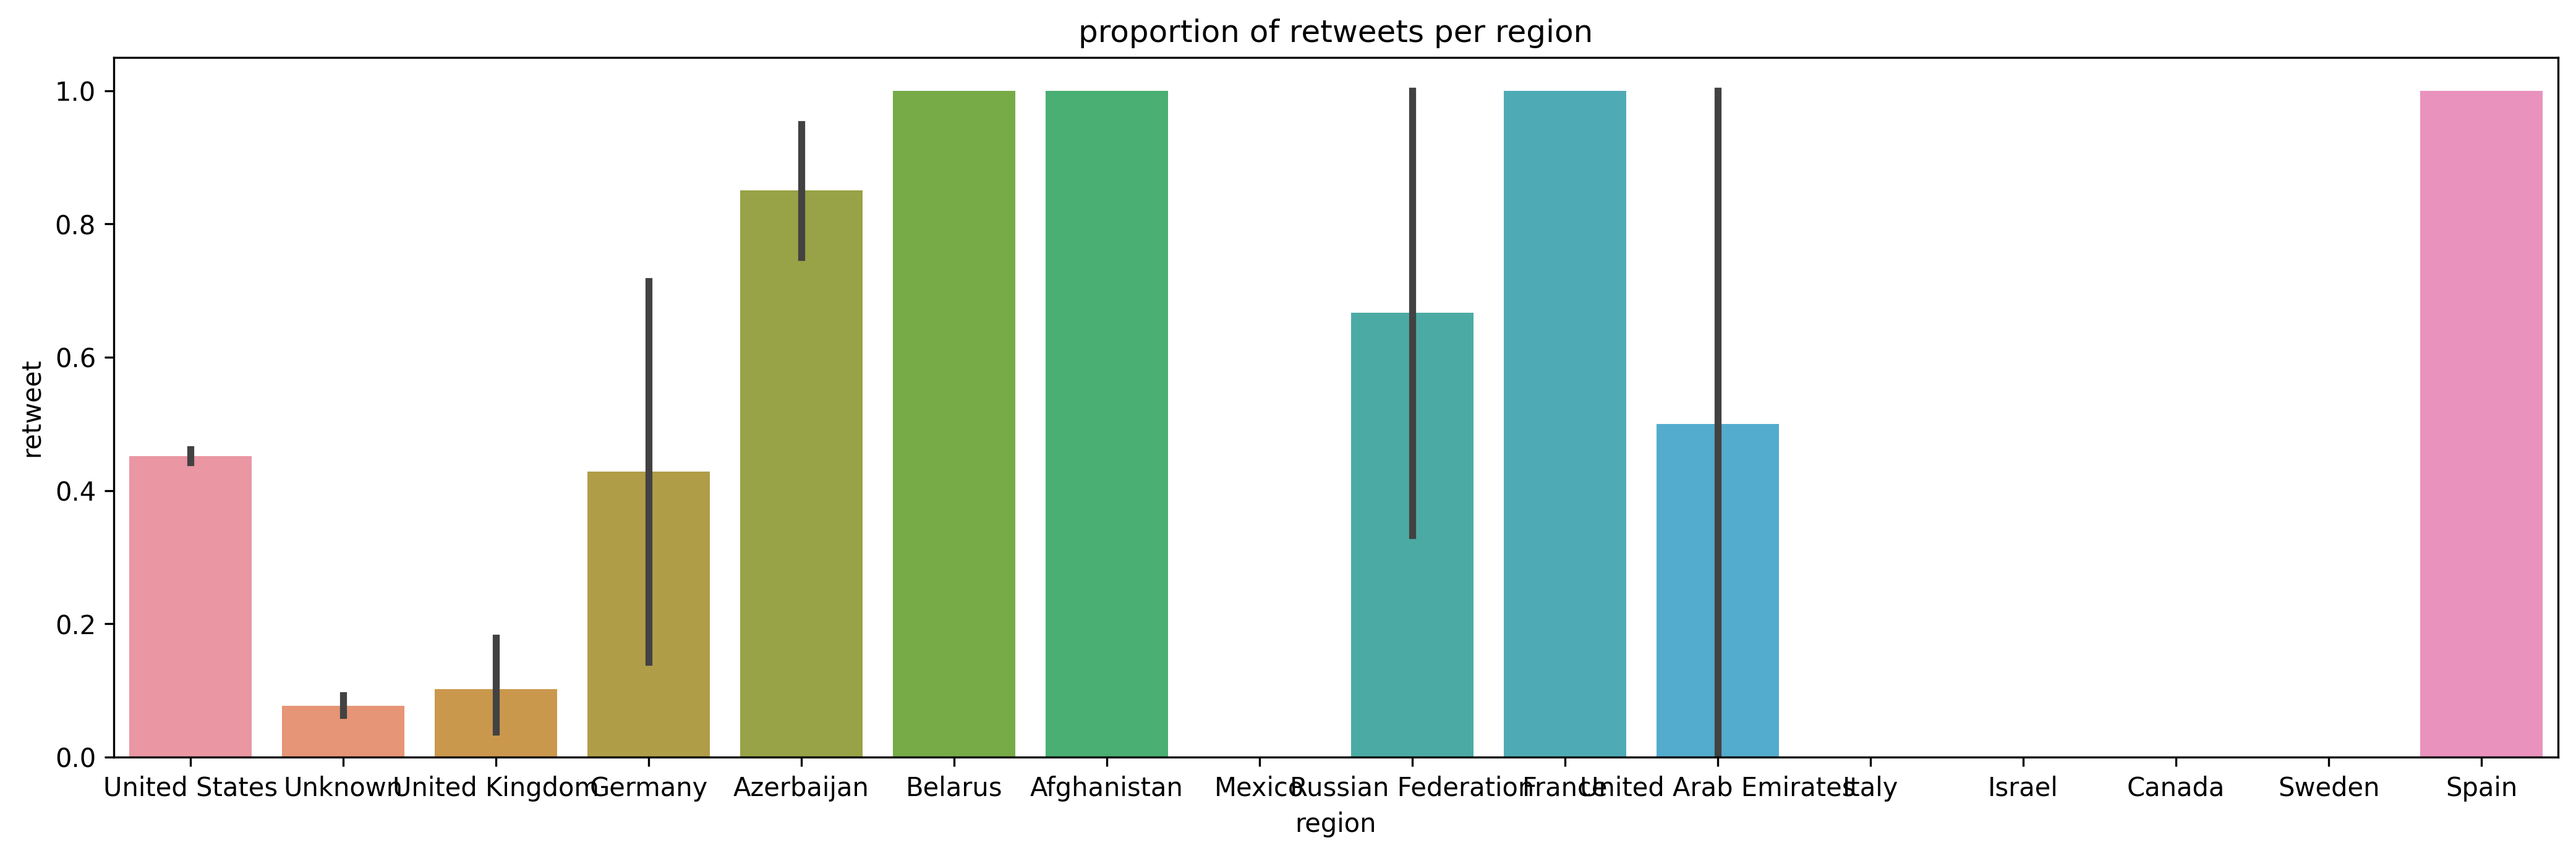

In [45]:
f, ax = plt.subplots(figsize=(17, 5))
ax = sns.barplot(x='region', y="retweet", data=df).set_title('proportion of retweets per region')
plt.show();

In [48]:
encoder = pipeline.named_steps['ordinalencoder']
X_val_encoded = encoder.transform(X_val)

model=pipeline
permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_encoded, y_val)

PermutationImportance(cv='prefit',
                      estimator=Pipeline(memory=None,
                                         steps=[('ordinalencoder',
                                                 OrdinalEncoder(cols=['region',
                                                                      'publish_date',
                                                                      'harvested_date',
                                                                      'account_type',
                                                                      'account_category'],
                                                                drop_invariant=False,
                                                                handle_missing='value',
                                                                handle_unknown='value',
                                                                mapping=[{'col': 'region',
                                                            

In [50]:
feature_names = X_val_encoded.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

following           0.176887
followers           0.156930
updates             0.074030
account_category    0.000000
account_type        0.000000
harvested_date      0.000000
publish_date        0.000000
region              0.000000
dtype: float64

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


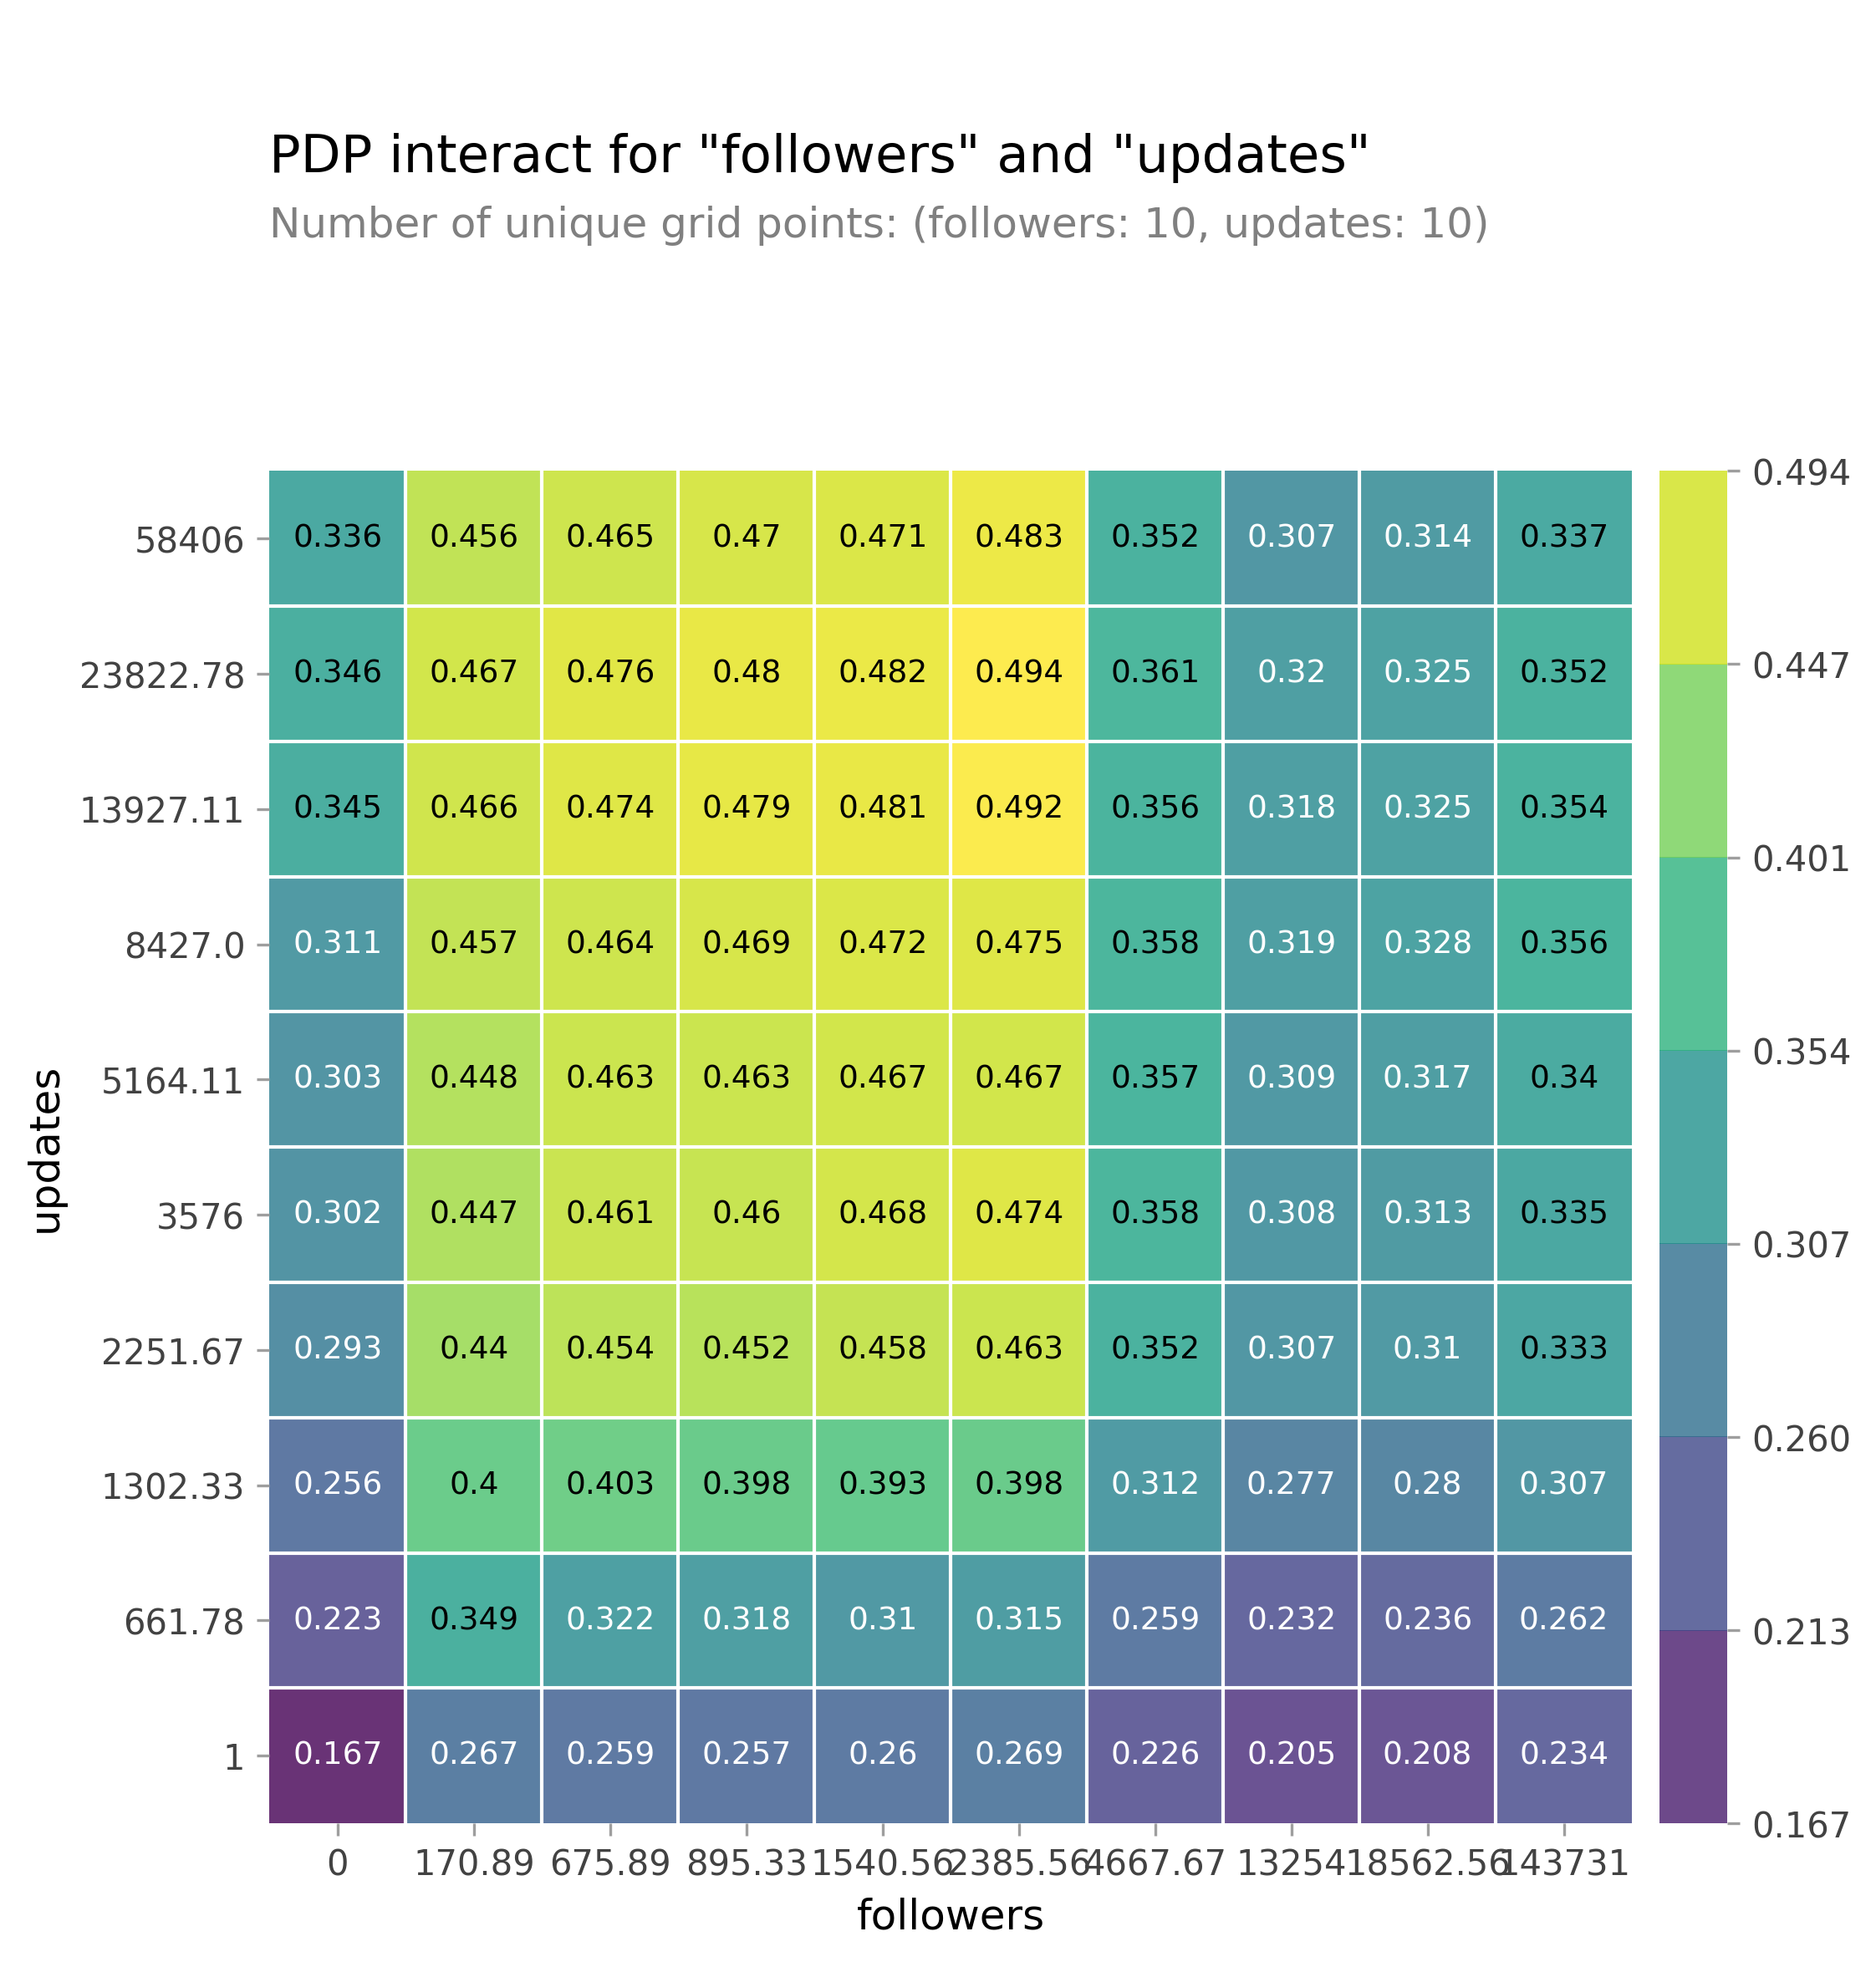

In [52]:
features = ['followers', 'updates']

interaction = pdp_interact(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);